# Florence2 + SAM2 Inference

In [2]:
# - Packages
import numpy as np
import torch
import cv2
import os

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

from torch.utils.data import Dataset, DataLoader

import torch
import supervision as sv

from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)

import numpy as np
import torch
import cv2
import os
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes

In [3]:
# - Global Variables
## - Florence2
data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image_pngs'
seg_image_dir = data_dir / 'seg_pngs'
test_image_dir = data_dir / 'image_test_pngs'


CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

label_num = 170

## - Define Dataloader
BATCH_SIZE = 5
NUM_WORKERS = 0

checkpoint_dir = './model_checkpoints/epoch_1000'

## - SAM2

data_dir= Path("./snemi/" )
raw_image_dir = data_dir / 'image_pngs'
seg_image_dir = data_dir / 'seg_pngs'
test_image_dir = data_dir / 'image_test_pngs'
sam2_checkpoint = "./sam2_hiera_large.pt"
model_cfg = "./sam2_hiera_l.yaml"
overlapp_ratio = 0.15
finetuned_parameter_path = "./checkpoints/large_model8163.torch"

In [5]:
# - Load Models
model = AutoModelForCausalLM.from_pretrained(checkpoint_dir, trust_remote_code=True).to(DEVICE)
processor = AutoProcessor.from_pretrained(checkpoint_dir, trust_remote_code=True)
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=DEVICE)
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(finetuned_parameter_path))

<All keys matched successfully>

## Data Preparation

In [11]:
all_files = np.sort(os.listdir(test_image_dir))
test_image_path_lst = np.array([data_dir / test_image_path for test_image_path in all_files])

array([PosixPath('snemi/image0000.png'), PosixPath('snemi/image0001.png'),
       PosixPath('snemi/image0002.png'), PosixPath('snemi/image0003.png'),
       PosixPath('snemi/image0004.png'), PosixPath('snemi/image0005.png'),
       PosixPath('snemi/image0006.png'), PosixPath('snemi/image0007.png'),
       PosixPath('snemi/image0008.png'), PosixPath('snemi/image0009.png'),
       PosixPath('snemi/image0010.png'), PosixPath('snemi/image0011.png'),
       PosixPath('snemi/image0012.png'), PosixPath('snemi/image0013.png'),
       PosixPath('snemi/image0014.png'), PosixPath('snemi/image0015.png'),
       PosixPath('snemi/image0016.png'), PosixPath('snemi/image0017.png'),
       PosixPath('snemi/image0018.png'), PosixPath('snemi/image0019.png'),
       PosixPath('snemi/image0020.png'), PosixPath('snemi/image0021.png'),
       PosixPath('snemi/image0022.png'), PosixPath('snemi/image0023.png'),
       PosixPath('snemi/image0024.png'), PosixPath('snemi/image0025.png'),
       PosixPath('snemi/i

## Florence2 and Sam2 Inference

### Florence2 Inference

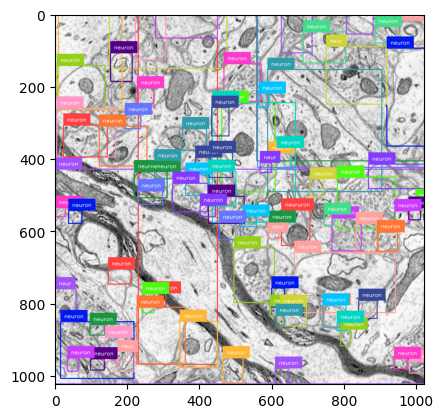

In [12]:
# - EM Test Image Sample Inference
image = cv2.imread(str(test_image_dir / 'image0001.png'))
image = Image.fromarray(image)
task = "<OD>"
text = "<OD>"

inputs = processor(
    text=text, 
    images=image, 
    return_tensors="pt"
).to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3)
generated_text = processor.batch_decode(
    generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(
    generated_text, 
    task=task, 
    image_size=image.size)
detections = sv.Detections.from_lmm(
    sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoxAnnotator(
    color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(
    color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
plt.imshow(image)

(88, 4)